In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Employee Demographics


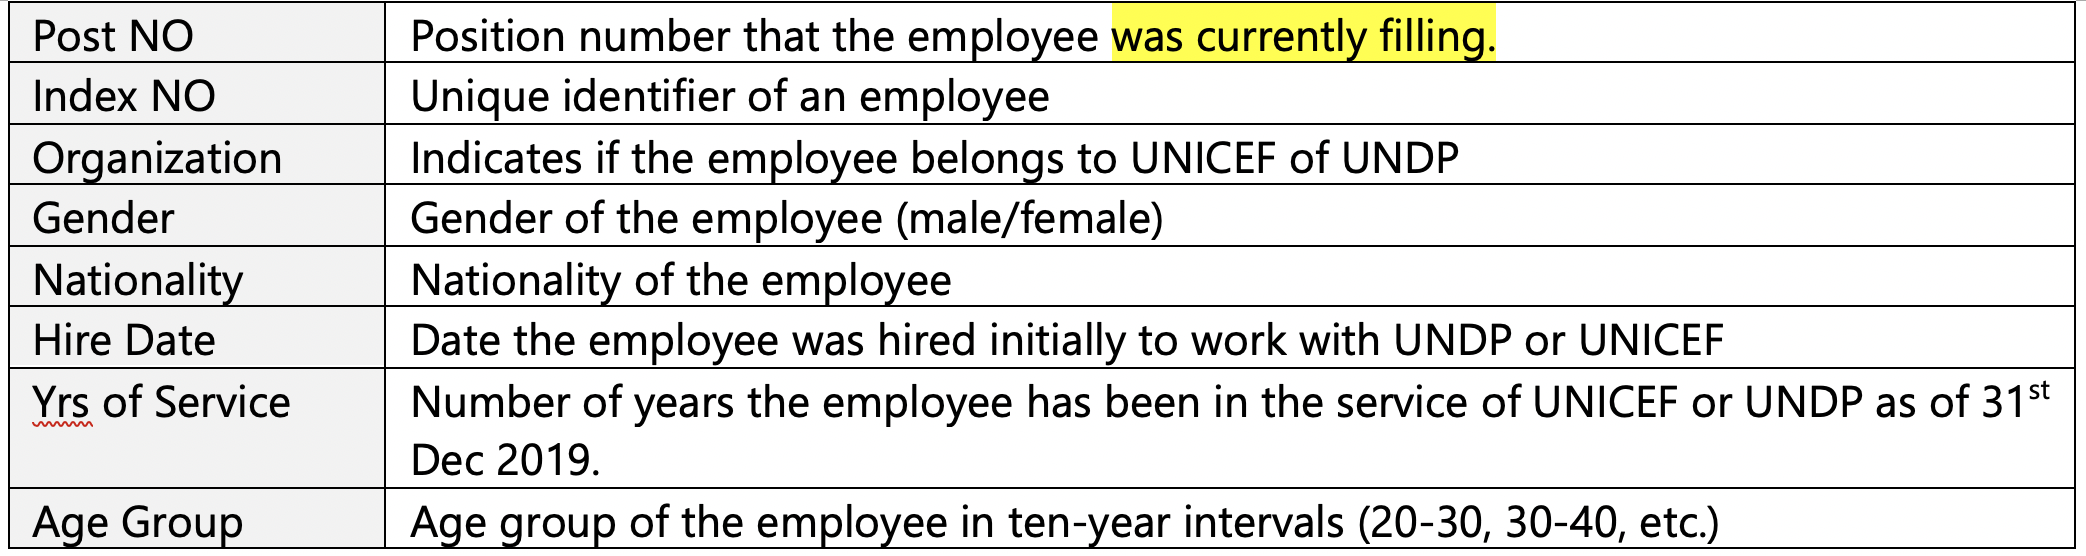

In [2]:
emp_de = pd.read_csv('Employee_Demographics.txt', sep=",", names=['Post No','Index No','Organization','Gender','Nationality','Hire Date','Yrs Of Service','Age Group', 'Others'])
emp_de = emp_de.iloc[1: , :]
emp_de.head()

Post No Index No Organization  Gender Nationality  \
1  SSSSZKOA   FSZKZS         UNDP  Female     Myanmar   
2  SSSSZKOR   SAZSKZ         UNDP    Male     Myanmar   
3  SSSSZKOP   SFZRXX         UNDP    Male     Myanmar   
4  SSSSZKKX   RSPXSR         UNDP  Female     Myanmar   
5  SSSSZKKA   XKRXPZ         UNDP    Male   Sri Lanka   

                 Hire Date Yrs Of Service Age Group Others  
1  1979-10-01 00:00:00.000             40     60-69    NaN  
2  2013-07-08 00:00:00.000              6     50-59    NaN  
3  1994-11-22 00:00:00.000             25     60-69    NaN  
4  1996-11-01 00:00:00.000             23     50-59    NaN  
5  1999-07-01 00:00:00.000             20     40-49    NaN

In [3]:
# Select rows only with normal 'Hire Date' & 'Nationality': Hire Date that doesn't contain letters. 

normal = emp_de[emp_de['Hire Date'].str.contains('\d', na=False, regex=True)] # 'Hire Date' with numbers
normal = normal.drop(['Others'], axis=1)

# There is 'Hire Date' with ' UNSCR1244 (1999)' as it contains numbers
# Remove it for now...
normal = normal[normal['Hire Date'] != ' UNSCR1244 (1999)']

# Select rows with abnormal 'Hire Date' which contains the following strings.
#' United Republic of',' Republic of',' The Democratic Republic',' UNSCR1244 (1999)'
#" Democratic People's Rep"," TFYR","Rep","Peo.Dem.Rep"," Federated States"," Dem. Rep"," Rep of"," DPR"

abnormal = emp_de[~emp_de['Hire Date'].str.contains('\d', na=False, regex=True)] # 'Hire Date' not with numbers
abnormal.head()


Post No Index No Organization  Gender Nationality            Hire Date  \
134  SSSSXXAO    DFXSO         UNDP    Male    Tanzania   United Republic of   
135  SSSSXXAF   PDKPXD         UNDP    Male    Tanzania   United Republic of   
136  SSSSXXAF   DZFADS         UNDP    Male    Tanzania   United Republic of   
137  SSSSXXAR    DOPXR         UNDP  Female    Tanzania   United Republic of   
138  SSSSXXRZ   AFKDOO         UNDP    Male    Tanzania   United Republic of   

              Yrs Of Service Age Group Others  
134  1999-12-01 00:00:00.000        20  70-79  
135  2013-07-01 00:00:00.000         6  50-59  
136  1998-07-01 00:00:00.000        21  50-59  
137  2002-01-16 00:00:00.000        18  50-59  
138  2016-06-01 00:00:00.000         3  30-39

In [4]:
# Combine 'Nationality' string and 'Hire Date' string as one country name
abnormal['Nationality'] = abnormal['Nationality'] + abnormal['Hire Date']

# Drop unnecessary column, 'Hire Date' and reassign column names
abnormal = abnormal.drop(['Hire Date'], axis=1)
abnormal.columns = ['Post No', 'Index No', 'Organization', 'Gender', 'Nationality',
       'Hire Date', 'Yrs Of Service', 'Age Group']

# Combine two cleaned dataframes
result = normal.append(abnormal)

# Remove "00:00:00.000"
result['Hire Date']= result['Hire Date'].str.replace("\s00:00:00.000", "")

# To datetime
result['Hire Date'] = pd.to_datetime(result['Hire Date'])

# Drop if 'Hire Date' has NaT
result = result[result['Hire Date'].notnull()]  

result['Yrs Of Service'] = result['Yrs Of Service'].astype('str')

# Drop if 'Yrs Of Service' is 'nan'
result = result[result['Yrs Of Service'] != 'nan']

# 'Yrs Of Service' into integer
result['Yrs Of Service'] = pd.to_numeric(result['Yrs Of Service']).astype('int')


In [5]:
#'Age Group' : Re-categorize
# Make the form of age categories consistent
result['Age Group']= result['Age Group'].str.replace("40 to 49", "40-49")
result['Age Group']= result['Age Group'].str.replace("30 to 39", "30-39")
result['Age Group']= result['Age Group'].str.replace("50 to 59", "50-59")

# Drop '#VALUE!' 
result['Age Group']= result['Age Group'][result['Age Group'] != '#VALUE!']

# Drop if 'Age Group' is NA
result = result[~result['Age Group'].isna()]

result['Age Group'].value_counts()

40-49           32075
30-39           28443
50-59           20026
60-69            3657
29 and below     2971
60 and above     2129
20-29            1480
70-79            1421
80-89             484
90-99             135
10-19               1
Name: Age Group, dtype: int64

People in Age Group '60 and above' : Predict the age of people in '60 and above' based on their 'Yrs Of Service'

* First, select people who are in 60-69, 70-79, 80-89, 90-99 (above60) and calculate the mean of each of their age.

* Next, get median of the mean ages, based on Yrs Of Service, using groupby 'Yrs Of Service'

* Then, predict the mean age of people in '60 and above' (a)

* Select people who are in below 60 (below60) and calculate the mean of each of their age category

* Finally, concat three groups of people, below60, a, above60.

In [6]:
# Put 2971 '29 and below' into '20-29', because 99.9% of employees in '29 and below' is in '20-29'
result['Age Group']= result['Age Group'].str.replace("29 and below", "20-29")

# People who are in 60-69, 70-79, 80-89, 90-99
above60 = result[result['Age Group'].isin(["60-69", "70-79", "80-89", "90-99"])]

# split by "-", and get the median 
above60['age']=above60['Age Group'].str.split('-')

# Calculate the mean of age based on the two numbers in 'Age Group' column, separated by "-".
above60['Age_mean'] = [(int(above60['age'].iloc[i][0]) + int(above60['age'].iloc[i][1]))/2 for i in range(len(above60))]

above60 = above60.drop('age', axis=1)

In [7]:
# Make a dictionary to see the depending on 'Yrs Of Service'
dict_for_age = above60.groupby(['Yrs Of Service']).agg({'Age_mean':'median'}).to_dict()['Age_mean']

# Apply the dictionary to the people in '60 and above'
The_60_and_above = result[result['Age Group'].isin(['60 and above'])]
The_60_and_above['Age_mean'] = The_60_and_above['Yrs Of Service'].map(dict_for_age)

# People in '60 and above' will mostly be 64.5 based on the median of others in above 60.
The_60_and_above['Age_mean'].value_counts()

64.5    2118
74.5      11
Name: Age_mean, dtype: int64

In [8]:
# Select people who are in below 60 (below60) and calculate the mean of each of their age category
below60 = result[~result['Age Group'].isin(["60-69", "70-79", "80-89", "90-99", "60 and above"])]

# split by "-", and get the median 
below60['age']=below60['Age Group'].str.split('-')

# Calculate the mean of age based on the two numbers in 'Age Group' column, separated by "-".
below60['Age_mean'] = [(int(below60['age'].iloc[i][0]) + int(below60['age'].iloc[i][1]))/2 for i in range(len(below60))]

below60 = below60.drop('age', axis=1)

# Finally, concat three groups of people, below60, a, above60.
employee = pd.concat([below60, above60, The_60_and_above])

# Change NAs into "Unknown"
# I didn't remove NAs in Nationality so that I can keep other more important information for better prediction
employee.Nationality[employee.Nationality.isna()] = 'Unknown'

employee.head()

Post No Index No Organization  Gender Nationality  Hire Date  \
2  SSSSZKOR   SAZSKZ         UNDP    Male     Myanmar 2013-07-08   
4  SSSSZKKX   RSPXSR         UNDP  Female     Myanmar 1996-11-01   
5  SSSSZKKA   XKRXPZ         UNDP    Male   Sri Lanka 1999-07-01   
7  SSSSZKFS   FDSZFP         UNDP    Male   Sri Lanka 2003-08-01   
8  SSSSZKFO    OOFDD         UNDP  Female       Sudan 2004-03-14   

   Yrs Of Service Age Group  Age_mean  
2               6     50-59      54.5  
4              23     50-59      54.5  
5              20     40-49      44.5  
7              16     40-49      44.5  
8              15     50-59      54.5

### Employee demographics -  Duplicates

Some employees took multiple positins in their years of service.
Dropped duplicates.

- Post No: Position number that the employee was currently filling.
- Index No: Unique identifier of an employee

In [9]:
print(len(employee))
print("The number of unique positions: "+ str(len(employee['Post No'].unique())))
print("The total number of employees: "+ str(len(employee['Index No'].unique())))

92822
The number of unique positions: 54281
The total number of employees: 48298


In [10]:
# Some rows have same 'Index No' & 'Post No'
employee[employee.duplicated(['Index No', 'Post No'],keep=False)].sort_values(by = ['Index No']).head()

Post No Index No Organization Gender        Nationality  Hire Date  \
84672   PZOFS   AAAAAZ       UNICEF   Male    Equatorial Guin 2016-03-01   
84401   PZOFS   AAAAAZ       UNICEF   Male  Equatorial Guinea 2016-03-01   
84400   PZOFS   AAAAAZ       UNICEF   Male    Equatorial Guin 2016-03-01   
84402   PZOFS   AAAAAZ       UNICEF   Male  Equatorial Guinea 2015-04-15   
56076   AFZXD   AAADFF       UNICEF   Male              Kenya 2011-05-01   

       Yrs Of Service Age Group  Age_mean  
84672               4     20-29      24.5  
84401               4     20-29      24.5  
84400               4     30-39      34.5  
84402               5     20-29      24.5  
56076               9     30-39      34.5

In [11]:
# Drop rows which have same 'Index No' & 'Post No'
employee1= employee.drop_duplicates(['Index No', 'Post No'])
employee1.head()

Post No Index No Organization  Gender Nationality  Hire Date  \
2  SSSSZKOR   SAZSKZ         UNDP    Male     Myanmar 2013-07-08   
4  SSSSZKKX   RSPXSR         UNDP  Female     Myanmar 1996-11-01   
5  SSSSZKKA   XKRXPZ         UNDP    Male   Sri Lanka 1999-07-01   
7  SSSSZKFS   FDSZFP         UNDP    Male   Sri Lanka 2003-08-01   
8  SSSSZKFO    OOFDD         UNDP  Female       Sudan 2004-03-14   

   Yrs Of Service Age Group  Age_mean  
2               6     50-59      54.5  
4              23     50-59      54.5  
5              20     40-49      44.5  
7              16     40-49      44.5  
8              15     50-59      54.5

In [12]:
print(len(employee1))
print(len(employee1['Post No'].unique()))
print(len(employee1['Index No'].unique()))

72874
54281
48298


In [13]:
# Employees who have been in multiple positions
employee1[employee1.duplicated(['Index No'],keep=False)].sort_values(by = ['Index No']).head()

Post No Index No Organization  Gender        Nationality  Hire Date  \
86474     PXRRS   AAAAAZ       UNICEF    Male  Equatorial Guinea 2015-04-15   
84400     PZOFS   AAAAAZ       UNICEF    Male    Equatorial Guin 2016-03-01   
34247  SSZSRZSX   AAADFF         UNDP    Male              Kenya 2008-11-10   
56076     AFZXD   AAADFF       UNICEF    Male              Kenya 2011-05-01   
72877     FPDAA    AAADK       UNICEF  Female      Cote d'Ivoire 2009-08-24   

       Yrs Of Service Age Group  Age_mean  
86474               5     20-29      24.5  
84400               4     30-39      34.5  
34247              11     40-49      44.5  
56076               9     30-39      34.5  
72877              11     30-39      34.5

# Employee Action


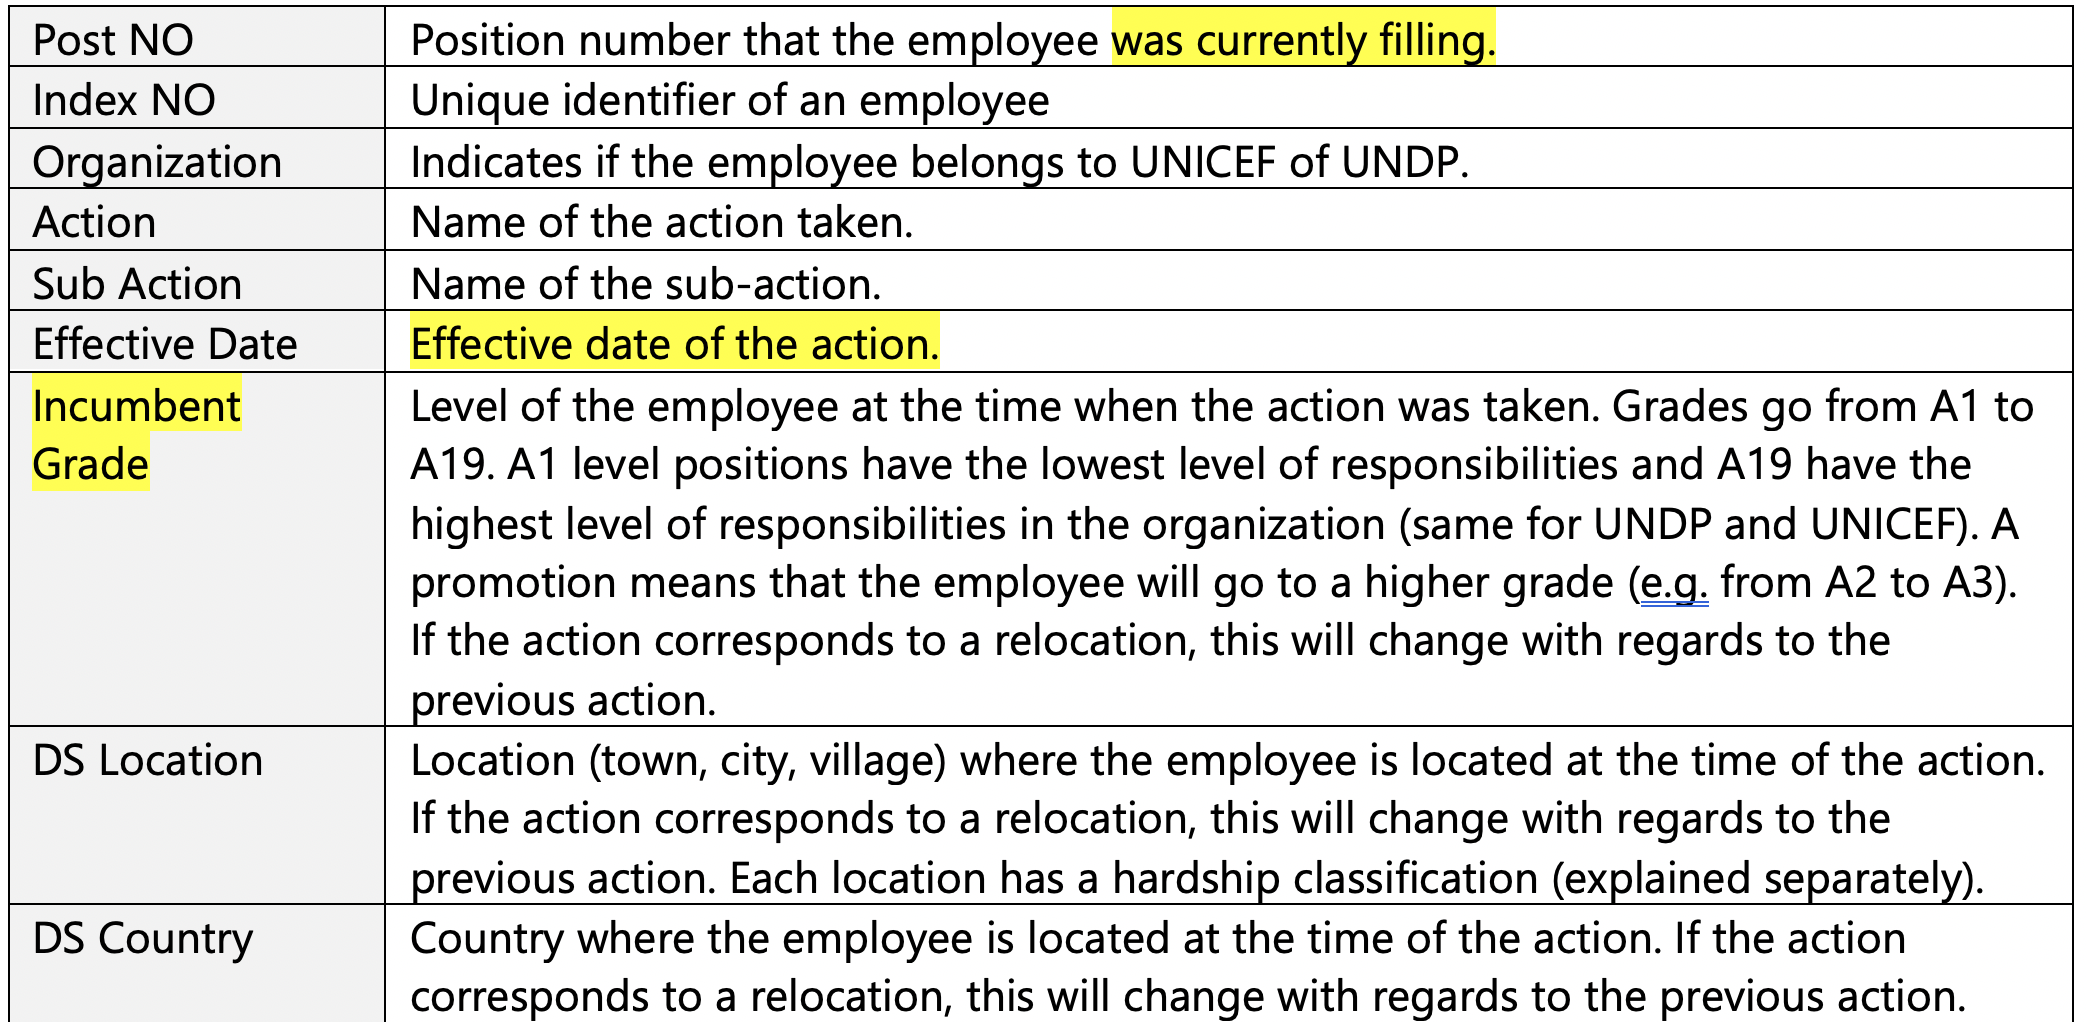

In [14]:
action = pd.read_csv('Employee_Actions.txt', sep='\t', encoding='latin1', dtype='unicode') #index_col=0,
action = action.iloc[:, :-1]

In [15]:
# Drop duplicates in Action data
action1 = action.drop_duplicates(subset = None, keep='first')
action1.head()

Post No Index No Organization                Action  \
0  SSSXAFRX   SFKFDO         UNDP           Data Change   
1  SSSXAFRX   SFKFDO         UNDP           Data Change   
2  SSSXAFRX   SFKFDO         UNDP           Data Change   
3  SSSXAFRX   SFKFDO         UNDP  Family Status Change   
4  SSSXAFRX   SFKFDO         UNDP  Family Status Change   

                       Sub Action Effective Date Incumbent Grade DS Location  \
0              Contract Extension     2015-02-17             A17     Yerevan   
1              Contract Extension     2017-02-17             A17     Yerevan   
2  IP Comp Review ? Step Matching     2017-01-01             A17     Yerevan   
3            Change/Add Dependent     2014-01-01             A17     Yerevan   
4            Change/Add Dependent     2016-05-20             A17     Yerevan   

  DS Country  
0    Armenia  
1    Armenia  
2    Armenia  
3    Armenia  
4    Armenia

In [16]:
# Variable of interest: 'Promotion'
promotion = action1[action1.Action == 'Promotion']
promotion['Sub Action'].value_counts()

Promotion                         6082
Promotion - Rank in Post          2799
Unknown                            146
Noncompetitive Career Promotio      41
Name: Sub Action, dtype: int64

In [17]:
# The number of people with promotion
len(promotion['Index No'].unique())

7644

In [18]:
len(employee1) + len(action1)

688186

In [19]:
# Join employee1 + action1
employee_and_action = pd.merge(employee1, action1, how='left', on=['Index No','Post No', 'Organization'])

In [20]:
employee_and_action.isna().sum()

Post No               0
Index No              0
Organization          0
Gender                0
Nationality           0
Hire Date             0
Yrs Of Service        0
Age Group             0
Age_mean              0
Action             2083
Sub Action         2030
Effective Date     2030
Incumbent Grade    2031
DS Location        2031
DS Country         2035
dtype: int64

In [21]:
# drop NA
employee_and_action.dropna(inplace = True)

In [22]:
# Change to Datetime object
employee_and_action['Effective Date'] = pd.to_datetime(employee_and_action['Effective Date'], errors='coerce').dt.strftime('%Y-%m-%d')
employee_and_action['Effective Date'] = pd.to_datetime(employee_and_action['Effective Date'], errors='coerce')

# Location
# Q) How do I join based on Date?? --> proper use of merge_asof() ??

- variable of interest: hardship classification


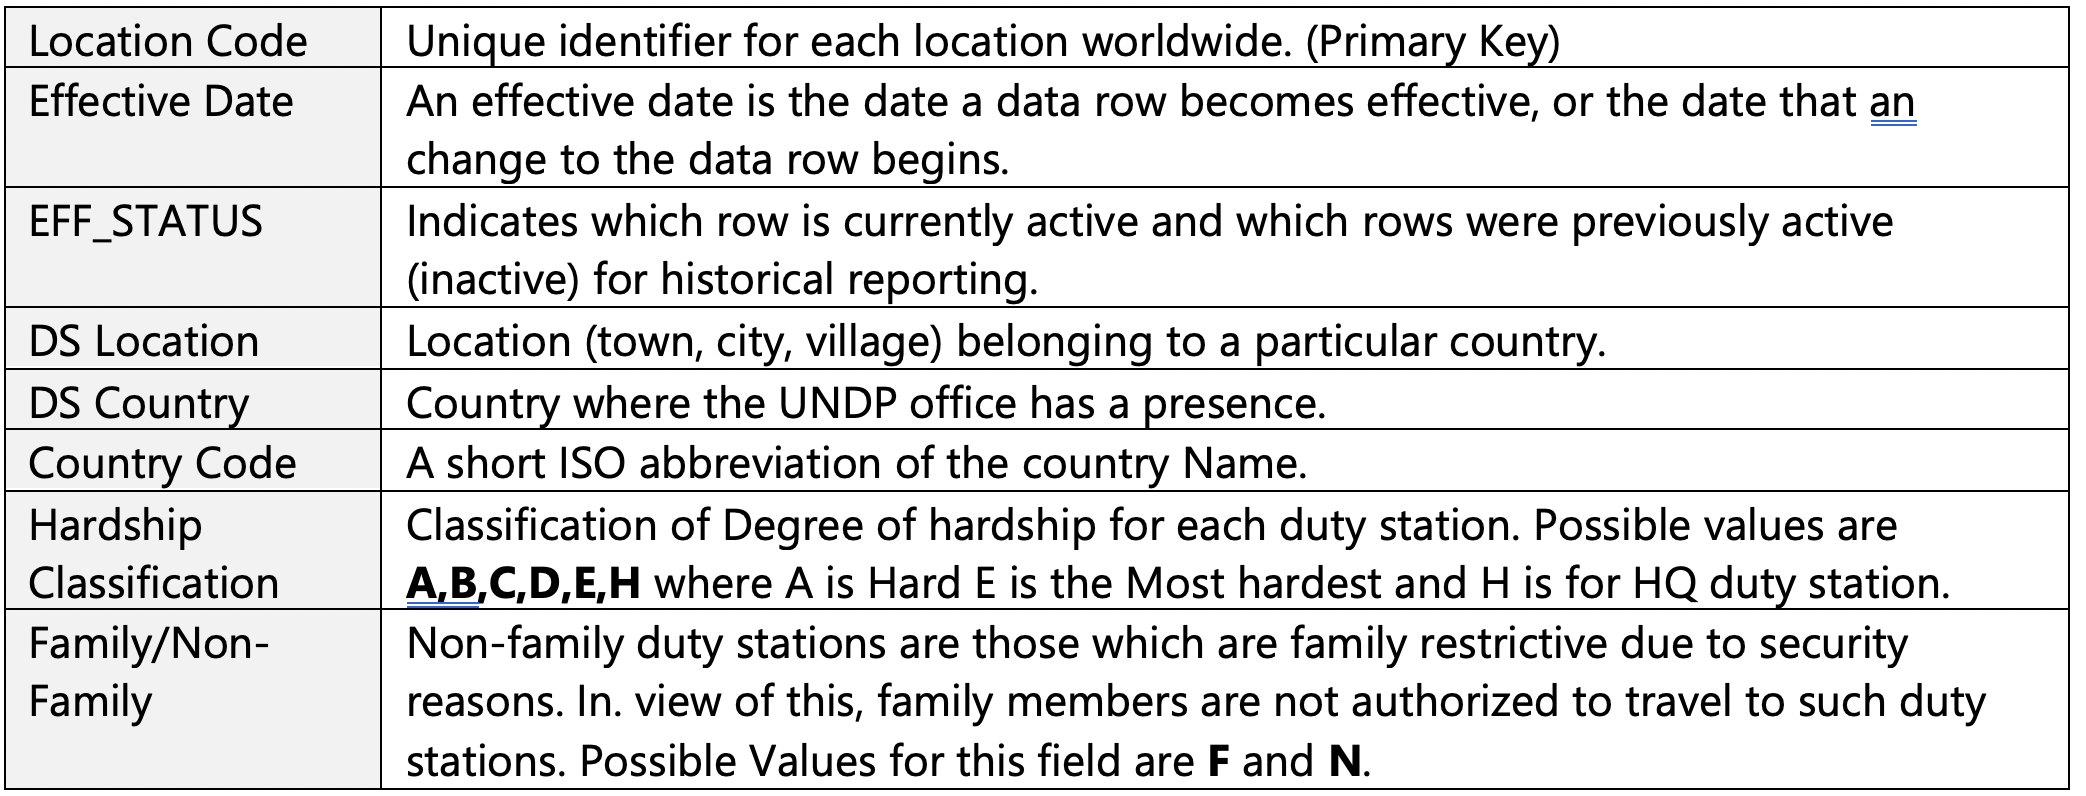

In [23]:
location = pd.read_excel('Location.xlsx')

In [24]:
location.head()

Location Code        EffDt Eff_Status DS Location   DS Country Country Code  \
0          0060  24.10.1946           A       Kabul  Afghanistan          AFG   
1          0060  01.01.1901           A       Kabul  Afghanistan          AFG   
2          0060  01.01.2007           A       Kabul  Afghanistan          AFG   
3          0060  20.02.2009           A       Kabul  Afghanistan          AFG   
4          0060  01.10.2008           A       Kabul  Afghanistan          AFG   

  Hardship Classification Family/Non-Family  
0                       E                 N  
1                       A                 F  
2                       E                 N  
3                       E                 N  
4                       E                 N

In [25]:
location[location['DS Location'] == 'Oecussi Ambeno']

Location Code        EffDt Eff_Status     DS Location  DS Country  \
6019          7067  01.05.2016           A  Oecussi Ambeno  East Timor   
6020          7067  01.01.2017           A  Oecussi Ambeno  East Timor   
6021          7067  01.01.2007           A  Oecussi Ambeno  East Timor   
6022          7067  01.01.1901           A  Oecussi Ambeno  East Timor   
6023          7067  01.07.2017           A  Oecussi Ambeno  East Timor   

     Country Code Hardship Classification Family/Non-Family  
6019          TLS                       E                 F  
6020          TLS                       D                 F  
6021          TLS                       E                 F  
6022          TLS                       A                 F  
6023          TLS                       D                 F

In [26]:
# Make EffDt as Year_month in order to join with existing dataset: 'join'
location['EffDt'] = pd.to_datetime(location['EffDt']).dt.strftime('%d-%m-%Y')
location['EffDt'] = pd.to_datetime(location['EffDt']).dt.strftime('%Y-%m-%d')
location['EffDt'] = pd.to_datetime(location['EffDt'])
#location['Year_month'] = pd.to_datetime(location['EffDt']).dt.strftime('%Y-%m')

In [27]:
# drop NA
employee_and_action.dropna(inplace = True)

In [28]:
# Use merge_asof function, as the two datasets do not have the exact same date information. 
asof = pd.merge_asof(employee_and_action.sort_values('Effective Date'), location.sort_values('EffDt'), left_on= 'Effective Date',right_on = 'EffDt', by =['DS Location','DS Country'])

In [29]:
asof.head()

Post No Index No Organization  Gender Nationality  Hire Date  \
0  SSSSDOXZ    DDXKP         UNDP    Male     Unknown 1954-01-01   
1  SSSSDOXZ   KDZODK         UNDP    Male     Unknown 1963-10-01   
2  SSSSDOXZ   KDZODK         UNDP    Male     Unknown 1963-10-01   
3  SSSSDOXZ   XSFKXP         UNDP  Female     Unknown 1963-12-04   
4  SSSSDOXZ   KAXFDR         UNDP  Female     Unknown 1964-01-01   

   Yrs Of Service Age Group  Age_mean      Action  ... Effective Date  \
0              66     90-99      94.5        Hire  ...     1954-01-01   
1              56     90-99      94.5  Retirement  ...     1963-10-01   
2              56     90-99      94.5        Hire  ...     1963-10-01   
3              56     80-89      84.5        Hire  ...     1963-12-04   
4              56     80-89      84.5        Hire  ...     1964-01-01   

  Incumbent Grade DS Location DS Country Location Code      EffDt Eff_Status  \
0              A3     Baghdad       Iraq          2130 1901-01-01          A   
1              A2     Algiers    Algeria          0120 1901-01-01          A   
2              A2     Algiers    Algeria          0120 1901-01-01          A   
3              A7     Baghdad       Iraq          2130 1901-01-01          A   
4              A6     Nicosia     Cyprus          1110 1901-01-01          A   

  Country Code Hardship Classification Family/Non-Family  
0          IRQ                       A                 F  
1          DZA                       A                 F  
2          DZA                       A                 F  
3          IRQ                       A                 F  
4          CYP                       A                 F  

[5 rows x 21 columns]

In [30]:
# drop NA
asof.dropna(inplace = True)

In [31]:
asof['Hardship Classification'].value_counts()

A    115677
B     88523
C     80062
H     59374
E     59332
D     55678
         17
Name: Hardship Classification, dtype: int64

In [32]:
# Change column names
asof = asof.rename(columns = {'Post No':'Current_Position'})

In [33]:
asof.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458663 entries, 0 to 557441
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Current_Position         458663 non-null  object        
 1   Index No                 458663 non-null  object        
 2   Organization             458663 non-null  object        
 3   Gender                   458663 non-null  object        
 4   Nationality              458663 non-null  object        
 5   Hire Date                458663 non-null  datetime64[ns]
 6   Yrs Of Service           458663 non-null  int64         
 7   Age Group                458663 non-null  object        
 8   Age_mean                 458663 non-null  float64       
 9   Action                   458663 non-null  object        
 10  Sub Action               458663 non-null  object        
 11  Effective Date           458663 non-null  datetime64[ns]
 12  Incumbent Grade 

# Performance

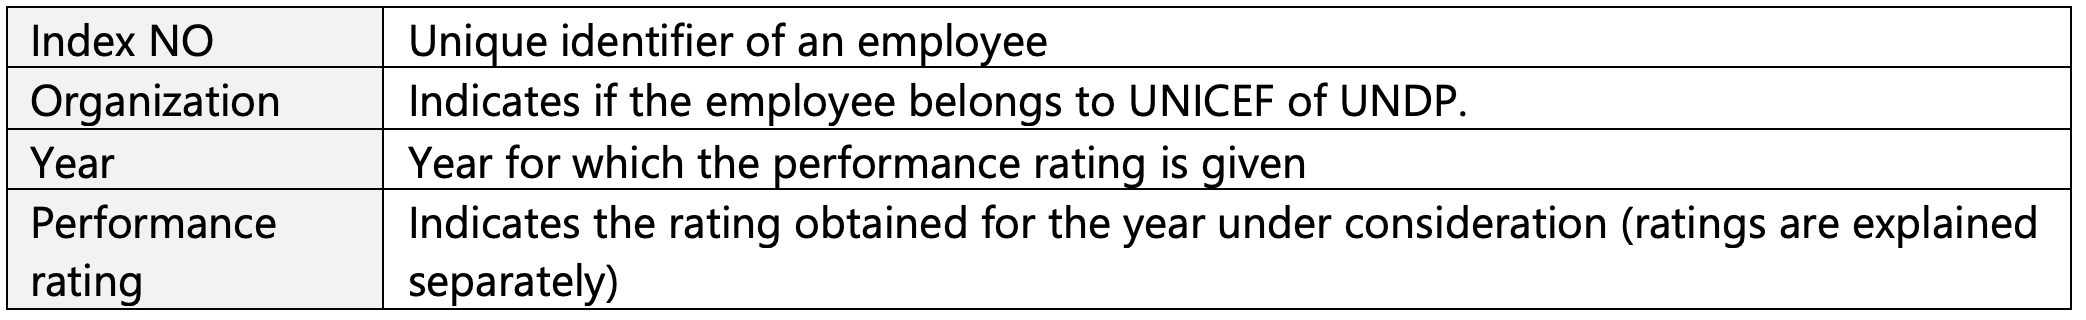

In [34]:
performance = pd.read_csv('Performance.txt', sep=",", names= ['Index No','Organization','Year','Performance Rating'])
performance = performance.iloc[1: , :]
performance.head()

Index No Organization  Year           Performance Rating
1   SSDFZF       UNICEF  2018            Solid Achievement
2   SSDFDP       UNICEF  2016            Solid Achievement
3   SSDOXR         UNDP  2017  Successful PLUS performance
4   SSDXFD       UNICEF  2016            Solid Achievement
5   SSDXKK       UNICEF  2017            Solid Achievement

In [35]:
asof.head()

Current_Position Index No Organization  Gender Nationality  Hire Date  \
0         SSSSDOXZ    DDXKP         UNDP    Male     Unknown 1954-01-01   
1         SSSSDOXZ   KDZODK         UNDP    Male     Unknown 1963-10-01   
2         SSSSDOXZ   KDZODK         UNDP    Male     Unknown 1963-10-01   
3         SSSSDOXZ   XSFKXP         UNDP  Female     Unknown 1963-12-04   
4         SSSSDOXZ   KAXFDR         UNDP  Female     Unknown 1964-01-01   

   Yrs Of Service Age Group  Age_mean      Action  ... Effective Date  \
0              66     90-99      94.5        Hire  ...     1954-01-01   
1              56     90-99      94.5  Retirement  ...     1963-10-01   
2              56     90-99      94.5        Hire  ...     1963-10-01   
3              56     80-89      84.5        Hire  ...     1963-12-04   
4              56     80-89      84.5        Hire  ...     1964-01-01   

  Incumbent Grade DS Location DS Country Location Code      EffDt Eff_Status  \
0              A3     Baghdad       Iraq          2130 1901-01-01          A   
1              A2     Algiers    Algeria          0120 1901-01-01          A   
2              A2     Algiers    Algeria          0120 1901-01-01          A   
3              A7     Baghdad       Iraq          2130 1901-01-01          A   
4              A6     Nicosia     Cyprus          1110 1901-01-01          A   

  Country Code Hardship Classification Family/Non-Family  
0          IRQ                       A                 F  
1          DZA                       A                 F  
2          DZA                       A                 F  
3          IRQ                       A                 F  
4          CYP                       A                 F  

[5 rows x 21 columns]

In [36]:
len(asof)

458663

In [37]:
four_datasets = pd.merge(asof, performance, on = ['Index No', 'Organization'])

In [38]:
four_datasets.sort_values(by=['Index No']).head(50).T

456538               456537  \
Current_Position                           PZOFS                PZOFS   
Index No                                  AAAAAZ               AAAAAZ   
Organization                              UNICEF               UNICEF   
Gender                                      Male                 Male   
Nationality                      Equatorial Guin      Equatorial Guin   
Hire Date                    2016-03-01 00:00:00  2016-03-01 00:00:00   
Yrs Of Service                                 4                    4   
Age Group                                  30-39                30-39   
Age_mean                                    34.5                 34.5   
Action                             Change in Pay      Contract Change   
Sub Action                  Grant Next Increment   Extend Appointment   
Effective Date               2018-03-01 00:00:00  2018-01-01 00:00:00   
Incumbent Grade                               A2                   A2   
DS Location                                 Bata                 Bata   
DS Country                     Equatorial Guinea    Equatorial Guinea   
Location Code                               1391                 1391   
EffDt                        2017-01-01 00:00:00  2017-01-01 00:00:00   
Eff_Status                                     A                    A   
Country Code                                 GNQ                  GNQ   
Hardship Classification                        D                    D   
Family/Non-Family                              F                    F   
Year                                        2017                 2016   
Performance Rating       Outstanding Achievement    Solid Achievement   

                                          456523               456524  \
Current_Position                           PZOFS                PZOFS   
Index No                                  AAAAAZ               AAAAAZ   
Organization                              UNICEF               UNICEF   
Gender                                      Male                 Male   
Nationality                      Equatorial Guin      Equatorial Guin   
Hire Date                    2016-03-01 00:00:00  2016-03-01 00:00:00   
Yrs Of Service                                 4                    4   
Age Group                                  30-39                30-39   
Age_mean                                    34.5                 34.5   
Action                             Reappointment        Reappointment   
Sub Action                         Reappointment        Reappointment   
Effective Date               2016-03-01 00:00:00  2016-03-01 00:00:00   
Incumbent Grade                               A2                   A2   
DS Location                                 Bata                 Bata   
DS Country                     Equatorial Guinea    Equatorial Guinea   
Location Code                               1391                 1391   
EffDt                        2014-07-01 00:00:00  2014-07-01 00:00:00   
Eff_Status                                     A                    A   
Country Code                                 GNQ                  GNQ   
Hardship Classification                        D                    D   
Family/Non-Family                              F                    F   
Year                                        2017                 2018   
Performance Rating       Outstanding Achievement    Solid Achievement   

                                      456525                456539  \
Current_Position                       PZOFS                 PZOFS   
Index No                              AAAAAZ                AAAAAZ   
Organization                          UNICEF                UNICEF   
Gender                                  Male                  Male   
Nationality                  Equatorial Guin       Equatorial Guin   
Hire Date                2016-03-01 00:00:00   2016-03-01 00:00:00   
Yrs Of Service                             4  

In [39]:
# 'Performance Rating' has lots of NAs because it's only for 3 years. 
four_datasets.isna().sum()

Current_Position               0
Index No                       0
Organization                   0
Gender                         0
Nationality                    0
Hire Date                      0
Yrs Of Service                 0
Age Group                      0
Age_mean                       0
Action                         0
Sub Action                     0
Effective Date                 0
Incumbent Grade                0
DS Location                    0
DS Country                     0
Location Code                  0
EffDt                          0
Eff_Status                     0
Country Code                   0
Hardship Classification        0
Family/Non-Family              0
Year                           0
Performance Rating         12305
dtype: int64

# Q) How can I clean this data? Due to Performance Rating, it became more messy. 
# Q) How to measure one's career success? (Promotion, Performance rating...)

# Internal Applicants

- Hired Index NO: will be filled with the Index NO of the candidate if he/she was SELECTED. 
- Post NO: Unique identifier of the position that the applicant is APPLYING to.
- Index NO 와 Hired Index NO가 일치하면, 그 사람은 성공한 것. 일치한 사람을 찾아서, 그 사람들의 특징을 보자. 
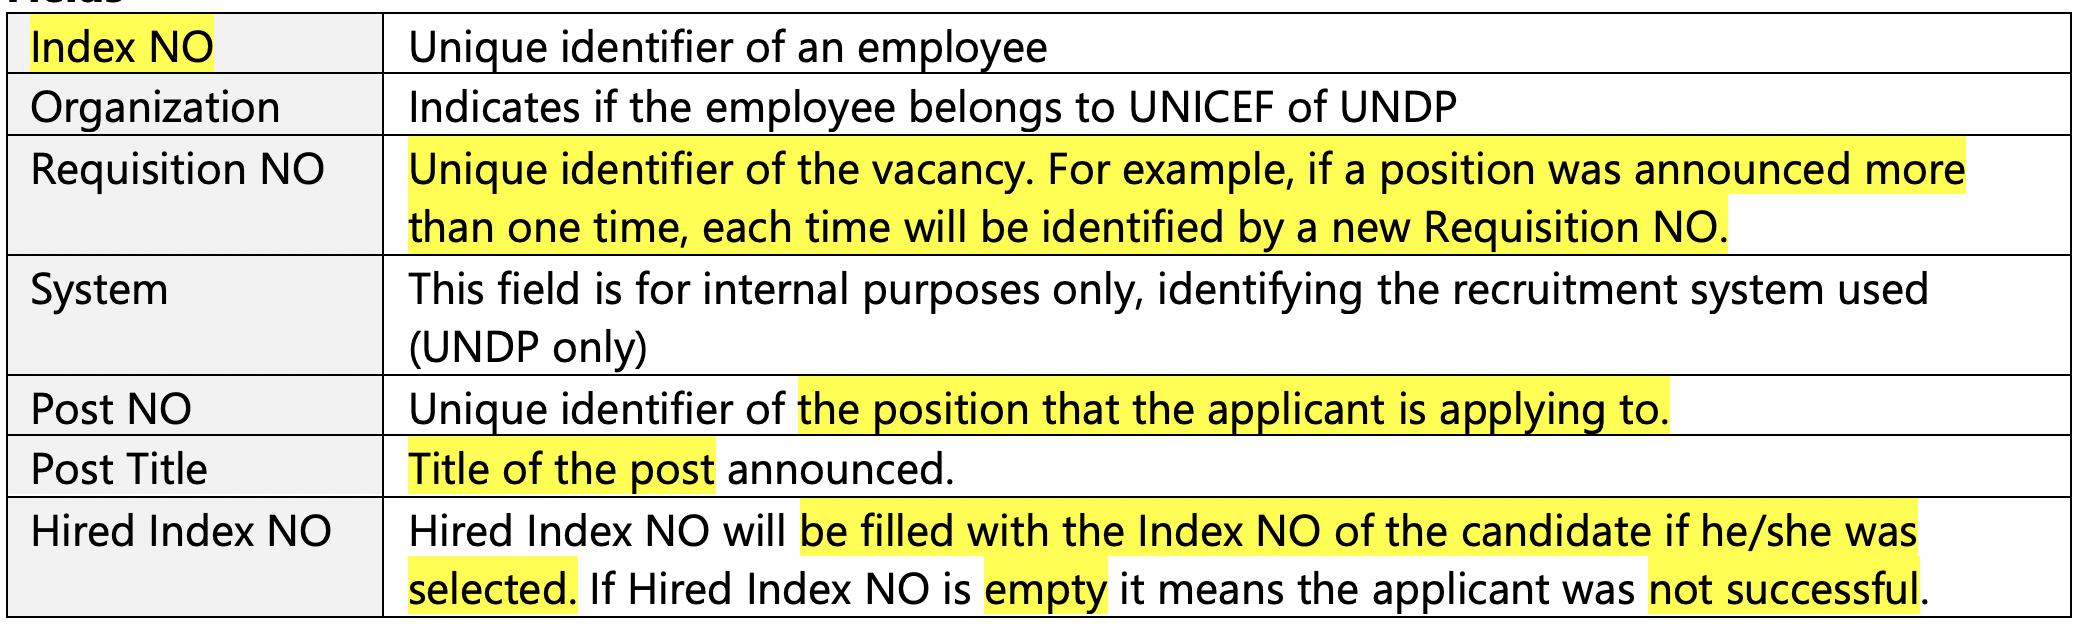

In [40]:
internal = pd.read_csv('Internal_Applicants.txt', 
                                  names = ['Index No', 'Organization', 'Requisition No', 'System', 'Post No', 'Post title', 'Hired Index NO'],
                                 sep=",",
                                 encoding='latin1', dtype='unicode')
internal = internal.iloc[1: , :]
internal.head()

Index No Organization Requisition No System   Post No  \
1   FRKPRZ         UNDP          35495     JS  SSSRRPPP   
2   FRKPKP         UNDP          52850     JS  SSSSSKKR   
3   FRKRFZ         UNDP          18759     ER  SSZOODSO   
4   FRKRFZ         UNDP          22152     ER  SSZKSOOK   
5   FRKRFZ         UNDP          23063     ER  SSZKZPSO   

                                          Post title Hired Index NO  
1  Re-advertised - Procurement and Supply Managem...            NaN  
2                       Programme Specialist Poverty            NaN  
3  Field Coordination and  Business Operations Sp...            NaN  
4                     Finance and Operations Analyst            NaN  
5                             Procurement Specialist            NaN

In [41]:
len(internal[internal.duplicated(subset = None, keep=False)==True])

0

# Summary of Vacancies
- Index NO: Unique identifier of the SELECTED candidate. 
- Post NO: Unique identifier of the position that the applicant is APPLYING to.
- Position Grade : Level of the position. 
    - Grades go from A1 to A19. 
    - A1 level positions have the lowest level of responsibilities and A19 have the highest level of responsibilities
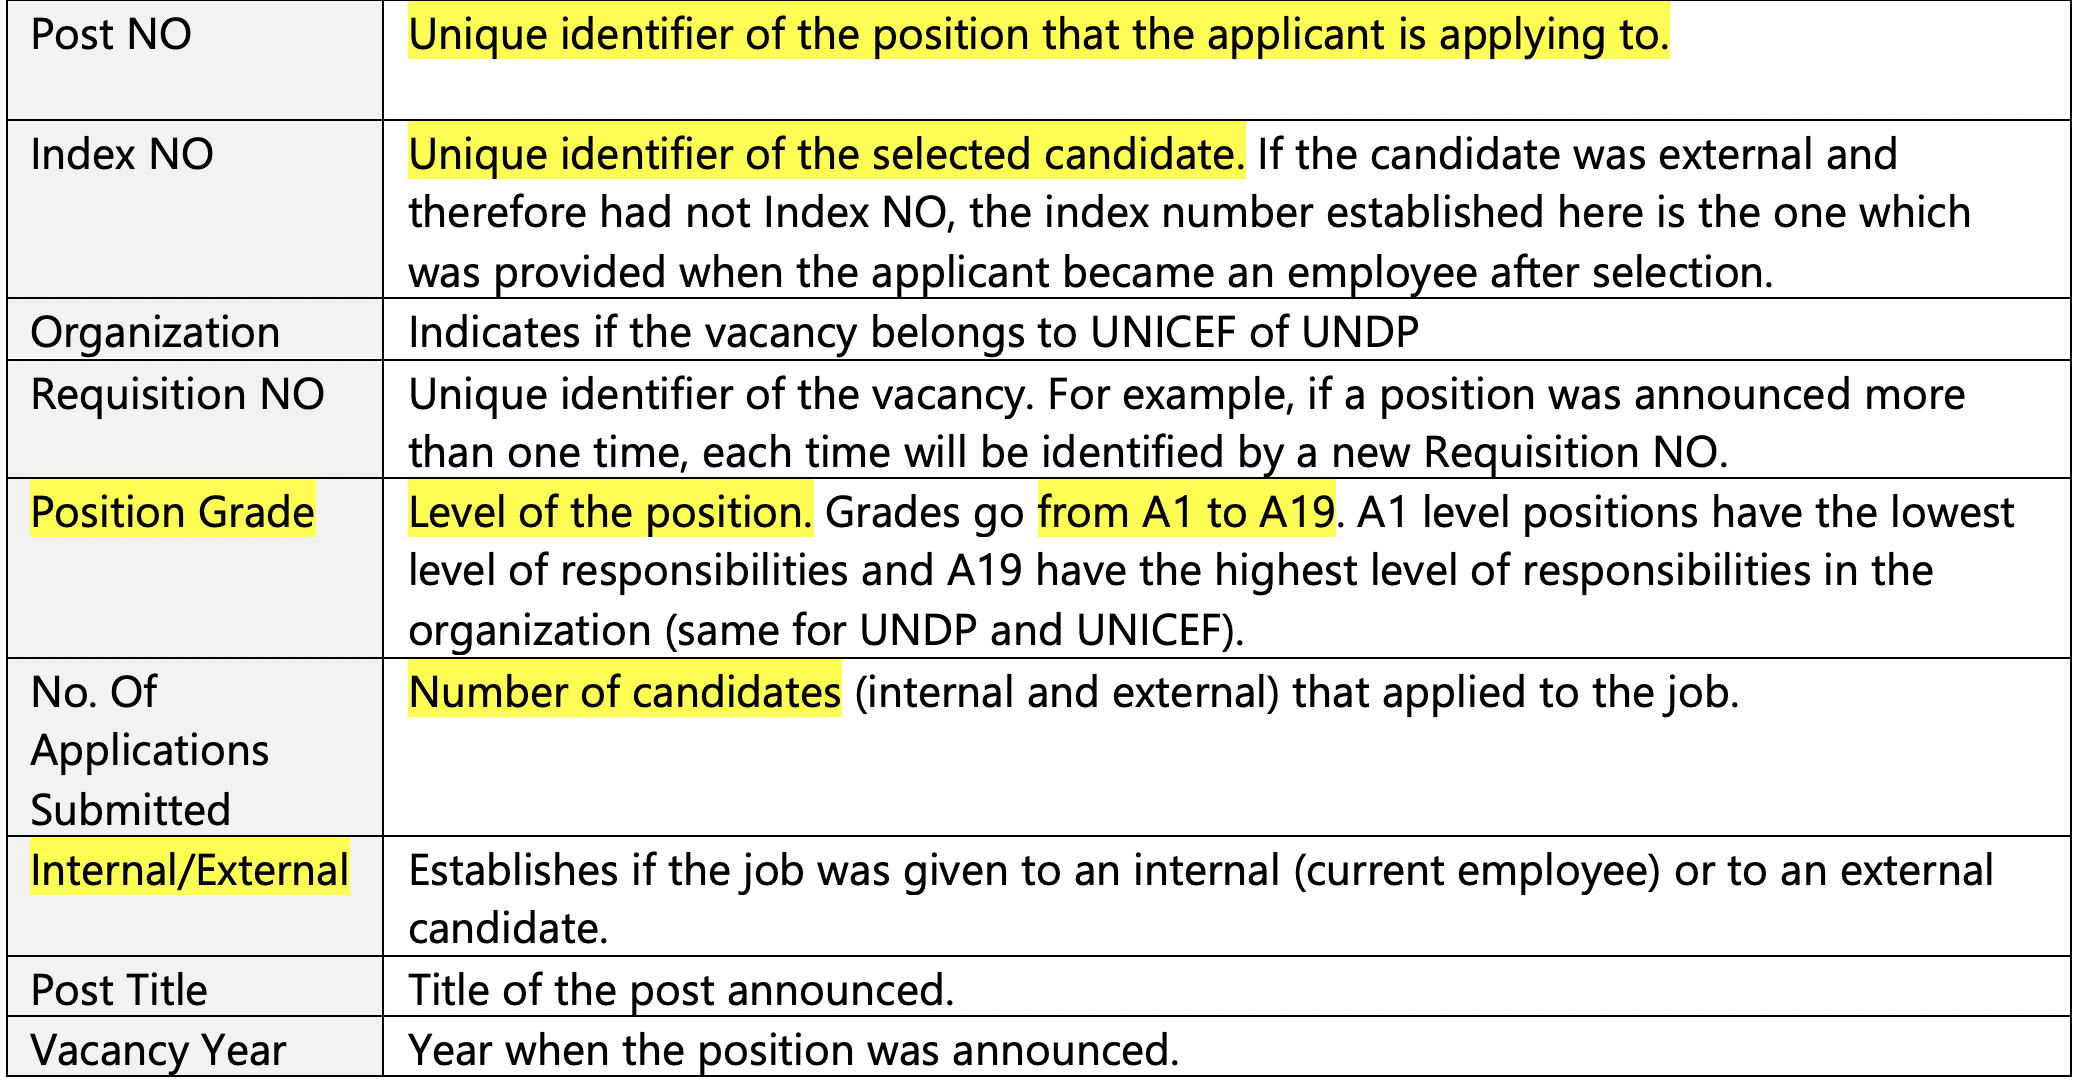

In [42]:
vacancy = pd.read_csv('Summary_of_Vacancies.txt', sep=",", 
                      names = ['Post No', 'Index No', 'Organization', 'Requisition No', 'Position Grade' , 'No of Applications Submitted', 'Internal / External', 'Post title', 'Vacancy Year'], 
                      encoding='latin1', dtype='unicode')
vacancy = vacancy.iloc[1: , :]

vacancy.head()

Post No Index No Organization Requisition No Position Grade  \
1  SSSSSXRF        Z         UNDP          24636             A6   
2  SSSSSXRA        Z         UNDP          32138             A7   
3  SSSSSXRA        Z         UNDP          33951             A7   
4  SSSSSXRA   SSPFFR         UNDP          36897             A7   
5  SSSSSXDS   SFXZRD         UNDP          32383             A9   

  No of Applications Submitted Internal / External  \
1                          218                 NaN   
2                          383                 NaN   
3                          275                 NaN   
4                          180            Internal   
5                          196            Internal   

                                          Post title Vacancy Year  
1  Programme Associate/Environment (For Rwandan n...         2011  
2   Programme Associate (For Rwandan nationals only)         2012  
3                     Programme Associate Governance         2012  
4  Programme Associate (Open to Rwandan Nationals...         2013  
5     Programme Analyst (For Rwandan nationals only)         2012

In [43]:
len(vacancy)

40121

In [44]:
len(vacancy[vacancy.duplicated(subset=None, keep=False)]) # too many duplicates

40120

In [45]:
# Drop duplicates

vacancy = vacancy.drop_duplicates(subset = None, keep='first').sort_values(by=['Index No'])
len(vacancy)

20061

In [46]:
# Join 'internal' & 'vacancy'

InternalApplicants_vacancy = pd.merge(internal, vacancy, how='left', on = ['Post No'])

In [47]:
InternalApplicants_vacancy.columns

Index(['Index No_x', 'Organization_x', 'Requisition No_x', 'System', 'Post No',
       'Post title_x', 'Hired Index NO', 'Index No_y', 'Organization_y',
       'Requisition No_y', 'Position Grade', 'No of Applications Submitted',
       'Internal / External', 'Post title_y', 'Vacancy Year'],
      dtype='object')

In [48]:
# Change column names
InternalApplicants_vacancy = InternalApplicants_vacancy.rename(columns={'Index No_x': 'Index No', 'Organization_x':'Organization', 'Index No_y':'Selected_Applicants','Organization_y':'Organization of Vacancy', 'Post No':'Position_applied_to'})

In [49]:
InternalApplicants_vacancy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 513459 entries, 0 to 513458
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Index No                      513459 non-null  object
 1   Organization                  513459 non-null  object
 2   Requisition No_x              513459 non-null  object
 3   System                        505744 non-null  object
 4   Position_applied_to           513459 non-null  object
 5   Post title_x                  513459 non-null  object
 6   Hired Index NO                84824 non-null   object
 7   Selected_Applicants           505872 non-null  object
 8   Organization of Vacancy       505864 non-null  object
 9   Requisition No_y              505872 non-null  object
 10  Position Grade                505872 non-null  object
 11  No of Applications Submitted  505872 non-null  object
 12  Internal / External           216486 non-null  object
 13 

In [50]:
InternalApplicants_vacancy.sort_values(by = ['Position_applied_to']).head()

Index No Organization Requisition No_x System Position_applied_to  \
287361   FDAFKA       UNICEF           498295    NaN               AADDK   
270846   FRROZX       UNICEF           498295    NaN               AADDK   
221192    DXDPX       UNICEF           498295    NaN               AADDK   
255114   AOFASK       UNICEF           498295    NaN               AADDK   
66844    OOARPS       UNICEF           498295    NaN               AADDK   

                       Post title_x Hired Index NO Selected_Applicants  \
287361  Chief Planning & Monitoring            NaN               DXDPX   
270846  Chief Planning & Monitoring            NaN               DXDPX   
221192  Chief Planning & Monitoring          Hired               DXDPX   
255114  Chief Planning & Monitoring            NaN               DXDPX   
66844   Chief Planning & Monitoring            NaN               DXDPX   

       Organization of Vacancy Requisition No_y Position Grade  \
287361                  UNICEF           498295            A15   
270846                  UNICEF           498295            A15   
221192                  UNICEF           498295            A15   
255114                  UNICEF           498295            A15   
66844                   UNICEF           498295            A15   

       No of Applications Submitted Internal / External  \
287361                          136            External   
270846                          136            External   
221192                          136            External   
255114                          136            External   
66844                           136            External   

                       Post title_y Vacancy Year  
287361  Chief Planning & Monitoring         2016  
270846  Chief Planning & Monitoring         2016  
221192  Chief Planning & Monitoring         2016  
255114  Chief Planning & Monitoring         2016  
66844   Chief Planning & Monitoring         2016

# Q) How should I join 'InternalApplicants_vacancy' and the 'four_datasets' above??

# I would like to make variables such as:

* To see their breath of experience: 
    - For each employee, how many different positions have they been in so far?
* To see if experience in hardship duty station leads to career success: 
    - For each employee, how many times have they been in hardship duty stations?
* To measure one's career success:
    - How many times they've been promoted?
    - How many grades in total they've gone up? Based on from which grade did they start & which grade are they at now?
    - Did they get job offer? what's their success rate?
    - How competitive was it?


[In korean]
만들고싶은 데이터/컬럼: 
    
<과정>
- 각 사람당: 얼마나 다양한 포지션에 있었는지 숫자, 얼마나 오래있었는지. 
- hardship duty 에 몇번 있었는지, 얼마나 오래 있었는지.

<결과>
- performance 점수가 어떤지 : 3년치 밖에 없기 때문에, 다른 variable 다 만든 다음에 3년치를 extract해내야함.  
- Promotion 얼마나 많이 했는지 숫자
- Grade level 올라간거 - 총 몇단계에서 시작해서 몇단계까지 올라갔는지. entire service 기간동안
- job offer 받은거: 지원한 것 중에 몇% 성공했는지.
